# Customers Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Data

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

For segmentation I am considering users from prior set only

In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [4]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [5]:
order_products.user_id.nunique()

206209

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [6]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [7]:
cross_df.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,...,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,...,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,...,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3


I will normalize each row

In [8]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [9]:
df.shape

(206209, 134)

### PCA and K-Means Clustering

Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [10]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088341,-0.104549,-0.116443,0.083694,-0.062523,-0.026177
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033960,-0.054736,-0.053366,-0.020370,-0.008092
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112238,-0.029812,0.007860,0.012277,0.001852
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019278,-0.025115,-0.038234,0.006492,-0.000623
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107649,-0.008034,0.103931,0.051732,-0.025799


In [11]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

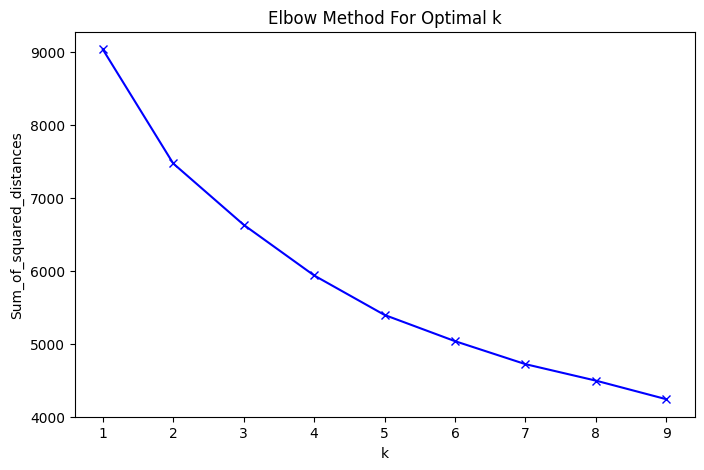

In [12]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [13]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 1.06014784e-01 -7.38379914e-02  1.74396734e-02  3.87809321e-03
   1.75355204e-03 -4.60825737e-03 -9.57181540e-04  1.24061217e-03
  -1.50381767e-04  8.09829353e-04]
 [-7.43999024e-02 -1.09864353e-02 -2.69320908e-02 -6.79322796e-03
  -6.90615099e-03  1.42620399e-03  5.36042938e-04 -2.58520679e-03
  -3.05334069e-04 -4.26580864e-04]
 [-1.98699104e-01  1.62568408e-02  3.18818778e-01 -3.14760973e-02
   1.87723514e-02  5.82002207e-04  4.06864830e-03  1.10131896e-02
   1.12972504e-03 -3.83898356e-03]
 [ 6.62901187e-02  1.03393881e-01 -1.52904065e-03 -3.09247154e-02
  -1.00551074e-02  7.52760482e-03 -5.67970256e-04  4.57422404e-03
  -7.71131246e-04 -1.64489796e-04]
 [-5.69755544e-03  1.31343027e-01  4.87847004e-03  2.29961160e-01
   1.09962968e-01 -2.29335049e-02  4.81512852e-05 -6.44061226e-03
   7.84273075e-03  3.05376071e-03]]


#### Visualizing clustering among first two principal components

In [14]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_16440\1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,1
1,-0.036988,0.108884,3
2,0.064282,0.103962,3
3,-0.093210,0.054093,1
4,0.094629,-0.037051,0


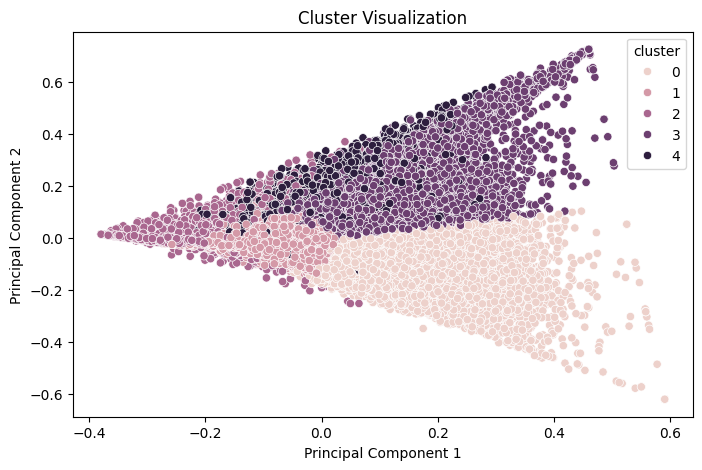

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [16]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [17]:
cluster1.shape

(55379, 135)

In [18]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.085159
fresh fruits                     21.650102
packaged vegetables fruits       11.980372
yogurt                            6.113762
packaged cheese                   4.990845
fresh herbs                       4.157876
milk                              3.974629
soy lactosefree                   3.694722
frozen produce                    3.293270
water seltzer sparkling water     3.070821
dtype: float64

In [19]:
cluster2.shape

(98656, 135)

In [20]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.657760
fresh vegetables                 7.538741
yogurt                           7.162555
packaged vegetables fruits       5.957519
packaged cheese                  4.915403
chips pretzels                   4.477224
milk                             4.233721
water seltzer sparkling water    4.096244
refrigerated                     3.251176
ice cream ice                    3.096811
dtype: float64

In [21]:
cluster3.shape

(5370, 135)

In [22]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.912663
fresh fruits                      3.303352
soft drinks                       2.809683
yogurt                            2.229795
energy granola bars               1.544693
tea                               1.323836
chips pretzels                    1.318808
milk                              1.314153
packaged vegetables fruits        1.219181
soy lactosefree                   1.070019
dtype: float64

In [23]:
cluster4.shape

(38848, 135)

In [24]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.675968
fresh vegetables                 15.210358
packaged vegetables fruits       12.197591
yogurt                           10.024145
milk                              6.005792
packaged cheese                   5.190692
soy lactosefree                   3.801483
water seltzer sparkling water     3.640162
bread                             3.229613
chips pretzels                    3.163149
dtype: float64

In [25]:
cluster5.shape

(7956, 135)

In [26]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.351684
fresh fruits                     10.903972
packaged vegetables fruits        4.236802
fresh vegetables                  3.101181
water seltzer sparkling water     1.714555
milk                              1.615385
packaged cheese                   1.543112
frozen produce                    1.147059
chips pretzels                    1.140020
nuts seeds dried fruit            1.032805
dtype: float64

Customer Segmentation Results:

- Cluster 1 results into 5428 consumers having a very strong preference for water seltzer sparkling water aisle.
- Cluster 2 results into 55784 consumers who mostly order fresh vegetables followed by fruits.
- Cluster 3 results into 7948 consumers who buy packaged produce and fresh fruits mostly.
- Cluster 4 results into 37949 consumers who have a very strong preference for fruits followed by fresh vegetables.
- Cluster 5 results into 99100 consumers who orders products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet. 